In [3]:
!pip install torchxrayvision

In [55]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchxrayvision as xrv
from torch.utils.data.sampler import SubsetRandomSampler

In [56]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224)])


d_covid19 = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",
                                   csvpath="covid-chestxray-dataset/metadata.csv",
                                   transform=transform)

In [57]:
d_covid19[0]['PA'].shape

(1, 224, 224)

In [4]:
print(d_covid19[0]["PA"][0].shape)
print(d_covid19.csv.iloc[0])

(224, 224)
patientid                                                                 2
offset                                                                    0
sex                                                                       M
age                                                                      65
finding                                                            COVID-19
survival                                                                  Y
intubated                                                               NaN
went_icu                                                                NaN
needed_supplemental_O2                                                  NaN
extubated                                                               NaN
temperature                                                             NaN
pO2_saturation                                                          NaN
leukocyte_count                                                         NaN
n

{'ARDS': 0.0,
 'Bacterial Pneumonia': 0.0,
 'COVID-19': 1.0,
 'Chlamydophila': 0.0,
 'Fungal Pneumonia': 0.0,
 'Klebsiella': 0.0,
 'Legionella': 0.0,
 'MERS': 0.0,
 'No Finding': 0.0,
 'Pneumocystis': 0.0,
 'Pneumonia': 1.0,
 'SARS': 0.0,
 'Streptococcus': 0.0,
 'Viral Pneumonia': 1.0}

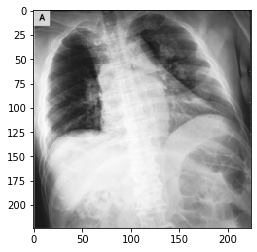

In [5]:
sample = d_covid19[0]
plt.imshow(sample["PA"][0], cmap="Greys_r");
dict(zip(d_covid19.pathologies,sample["lab"]))

In [6]:
dataset = []

for data in d_covid19:
    image = data["PA"][0]
    label = data["lab"][2]
    dataset.append((image, label))

In [7]:
len(dataset)

177

In [8]:
batch_size = 5
validation_split = .2
shuffle_dataset = True
random_seed= 420

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [9]:
# Creating data samplers:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [81]:
# Creating data loaders:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=2)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, 
                                                num_workers=2)

In [107]:
for images, labels in train_loader:
    img = images.unsqueeze(1)
    print(img.shape)
    break

torch.Size([5, 1, 224, 224])


In [142]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import AdamW, SGD

### Have to change the layers and their arguments
class XRayNet(nn.Module):
    def __init__(self):
        super(XRayNet, self).__init__()
        
        # input image size 3, 224, 224
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.batch1 = nn.BatchNorm2d(32, affine=True, track_running_stats=True)
        
        # image size 8, 112, 112
        self.conv2 = nn.Conv2d(32, 56, 3, stride = 1, padding = 1)
        self.batch2 = nn.BatchNorm2d(56, affine=True, track_running_stats=True)
        
        # image size 16, 56, 56
        self.conv3 = nn.Conv2d(56, 64, 3, stride = 1, padding = 1)
        self.batch3 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.conv4 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.batch4 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # input size 32, 28, 28
        self.fc1 = nn.Linear(64 * 13 * 13, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 2)
        
        self.batch5 = nn.BatchNorm1d(512)
        self.batch6 = nn.BatchNorm1d(64)
        
        self.drop = nn.Dropout(p=.3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pool(self.batch1(x))
        
        x = F.relu(self.conv2(x), inplace=True)
        x = self.pool(self.batch2(x))
        x = self.drop(x)
        
        x = F.relu(self.conv3(x), inplace=True)
        x = self.pool(self.batch3(x))
        x = self.drop(x)
        
        x = F.relu(self.conv4(x), inplace=True)
        x = self.pool(self.batch4(x))
        
        x = x.view(-1, 64 * 13 * 13)
        
        x = self.fc1(x)
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.batch5(x)
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.batch6(x)
        x = self.drop(x)
        x = self.softmax(self.fc4(x))
        
        return x

In [143]:
# defining the model
model = XRayNet()

print(model)
print(len(list(model.parameters())))
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

XRayNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)

In [144]:
# defining the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# defining the loss function
criterion = CrossEntropyLoss()

use_cuda = False
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    use_cuda = True

In [148]:
n_epoch = 30
min_val_loss = np.Inf

train_losses = []
val_losses = []

for e in range(n_epoch):
    
    running_loss = 0
    val_loss = 0
    
    # train mode
    for images, labels in train_loader:
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
        images = images.unsqueeze(1)
        
        # zero grad
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output, labels.long())
        
        running_loss += loss.item() * images.size(0)
        
        loss.backward()
        
        optimizer.step()
        
    # valid mode
    for images, labels in validation_loader:
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
        images = images.unsqueeze(1)
        model.eval()
        
        output = model(images)
        
        loss = criterion(output, labels.long())
        
        val_loss += loss.item() * images.size(0)
        
    model.train()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_val_loss = val_loss / len(validation_loader.dataset)
    print('Epoch {}, train loss : {}, validation loss :{}'.format(e, epoch_train_loss, epoch_val_loss))
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if epoch_val_loss <= min_val_loss:
        print('Validation loss decreased {} -> {}. Saving model...'.format(min_val_loss, epoch_val_loss))
        min_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best.pth')

Epoch 0, train loss : 0.4870239423829957, validation loss :0.11517946834618088
Validation loss decreased inf -> 0.11517946834618088. Saving model...
Epoch 1, train loss : 0.5000041841113635, validation loss :0.12776686646844035
Epoch 2, train loss : 0.4588923082176575, validation loss :0.11199563573309257
Validation loss decreased 0.11517946834618088 -> 0.11199563573309257. Saving model...
Epoch 3, train loss : 0.4937160727331194, validation loss :0.10700259252456622
Validation loss decreased 0.11199563573309257 -> 0.10700259252456622. Saving model...
Epoch 4, train loss : 0.4570568025448902, validation loss :0.12114394182539255
Epoch 5, train loss : 0.4480858285211574, validation loss :0.11361518232835888
Epoch 6, train loss : 0.4798572937310752, validation loss :0.1389306143852277
Epoch 7, train loss : 0.4569245494354916, validation loss :0.12580841779708862
Epoch 8, train loss : 0.48252487637228886, validation loss :0.12312083847105167
Epoch 9, train loss : 0.4647807470485989, valid

In [149]:
#Loading best model

XRayModel1 = XRayNet()
XRayModel1.load_state_dict(torch.load('best.pth'))

if use_cuda:
    XRayModel1.cuda()

In [ ]:
#Testing